In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
import seaborn as sns

In [4]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppi_vgg16
from tensorflow.keras.models import Sequential

In [6]:
import os
import warnings

In [7]:
warnings.filterwarnings("ignore")

# CONSTANTS

In [8]:
RAW_DATA_FILE_PATH = 'data/raw/'                # path to raw data folder
CLEANED_DATA_FILE_PATH = 'data/cleaned/'        # path to cleaned data folder
IMAGES_DIR = "data/raw/"                        # path to images

# FUNCTIONS

In [9]:
def preprocess_images(ppi,my_new_model):
    feature_list = []

    image_num = 0

    for path, subdirs, files in os.walk(RAW_DATA_FILE_PATH):
        for name in files:
            image_num = image_num + 1
            if image_num%10 == 0 : print(image_num,name)
            file = os.path.join(path, name)
            im = imread(file)
            img = ppi(np.expand_dims(im.copy(), axis=0))
            feature = my_new_model.predict(img)
            feature_np = np.array(feature)
            feature_list.append(feature_np.flatten())
    array = np.array(feature_list)
    return array

In [10]:
def run_model(model,ppi):
    my_new_model = Sequential()
    my_new_model.add(model)
    # Say not to train first layer model. It is already trained
    my_new_model.layers[0].trainable = False
    array = preprocess_images(ppi,my_new_model)
    return array

# READ IMAGES, CREATE DATAFRAME

In [11]:
# read images, create df of filenames, and class (which type)

fv = pd.DataFrame(columns=['filename','fv_class'])

for path, subdirs, files in os.walk(RAW_DATA_FILE_PATH):
    for name in files:
        subfolder_name = path.replace(RAW_DATA_FILE_PATH,'')
        fv.loc[len(fv)] = [name,subfolder_name]
        
fv.head()

,filename,fv_class
0,0_100.jpg,banana
1,128_100.jpg,banana
2,180_100.jpg,banana
3,270_100.jpg,banana
4,35_100.jpg,banana


# VECTORIZATION BY VGG16

In [12]:
#model = VGG16(include_top=False, pooling='avg', weights='imagenet')
model = VGG16(include_top=False, weights='imagenet')
array = run_model(model,ppi_vgg16)


10 235_100.jpg
20 100_100.jpg
30 158_100.jpg


# SCALING

In [13]:
scaler = StandardScaler()

array_scaled = scaler.fit_transform(array)

In [15]:
print (array.shape)
print (array_scaled.shape)

(31, 4608)
(31, 4608)


# CREATE VECTOR DATAFRAME FROM VGG16 RESULTS

In [16]:
# create df from model vector
df_vec = pd.DataFrame(array_scaled)

# add image filename and category
df_vec['filename'] = fv.filename
df_vec['fv_class'] = fv.fv_class

df_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,4600,4601,4602,4603,4604,4605,4606,4607,filename,fv_class
0,-0.356363,-0.247777,-0.548079,-0.260071,-0.252961,0.0,0.0,0.0,0.0,0.0,...,-0.292827,0.0,-0.182574,0.0,0.0,0.0,1.929718,-0.186526,0_100.jpg,banana
1,-0.356363,4.897294,-0.548079,3.224580,2.437803,0.0,0.0,0.0,0.0,0.0,...,4.756949,0.0,-0.182574,0.0,0.0,0.0,-0.313065,-0.186526,128_100.jpg,banana
2,-0.356363,-0.247777,-0.548079,-0.260071,-0.252961,0.0,0.0,0.0,0.0,0.0,...,-0.292827,0.0,5.477226,0.0,0.0,0.0,2.654601,-0.186526,180_100.jpg,banana
3,-0.356363,-0.247777,-0.548079,-0.260071,-0.252961,0.0,0.0,0.0,0.0,0.0,...,-0.292827,0.0,-0.182574,0.0,0.0,0.0,4.181507,-0.186526,270_100.jpg,banana
4,-0.356363,-0.247777,-0.548079,-0.260071,-0.252961,0.0,0.0,0.0,0.0,0.0,...,-0.292827,0.0,-0.182574,0.0,0.0,0.0,-0.313065,5.476000,35_100.jpg,banana


# RUN PCA FOR REDUCTION TO 2 COMPONENTS

In [17]:
# define pca
pca = decomposition.PCA(n_components=2)

# run pca
array_pca_out = pca.fit_transform(df_vec.drop(columns=['filename','fv_class']))

# pca results to dataframe
df_pca = pd.DataFrame(array_pca_out)

# add filename and category
df_pca['filename'] = df_vec['filename']
df_pca['fv_class'] = df_vec['fv_class']

df_pca.head()

,0,1,filename,fv_class
0,-8.235987,40.053181,0_100.jpg,banana
1,-2.621400,33.443474,128_100.jpg,banana
2,-6.802118,23.259010,180_100.jpg,banana
3,-6.480217,48.968109,270_100.jpg,banana
4,-5.276463,15.363815,35_100.jpg,banana


# MATPLOTLIB SCATTER PLOT

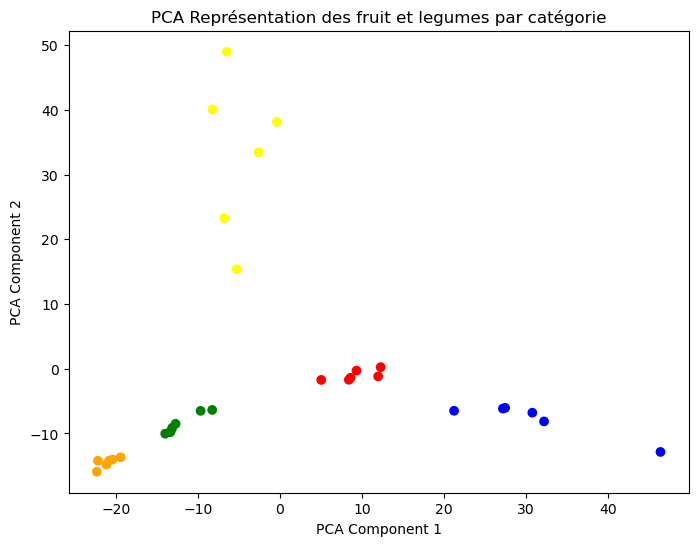

In [18]:
# start plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# colormap for scatterplot
colours = {'pear':'green',
    'banana':'yellow',
    'cauliflower':'blue',
    'ginger':'red',
    'grannysmith':'orange'}

scatter = ax.scatter(df_pca[0],df_pca[1],c=df_pca['fv_class'].map(colours))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Représentation des fruit et legumes par catégorie')
plt.show()

# SEABORN SCATTERPLOT

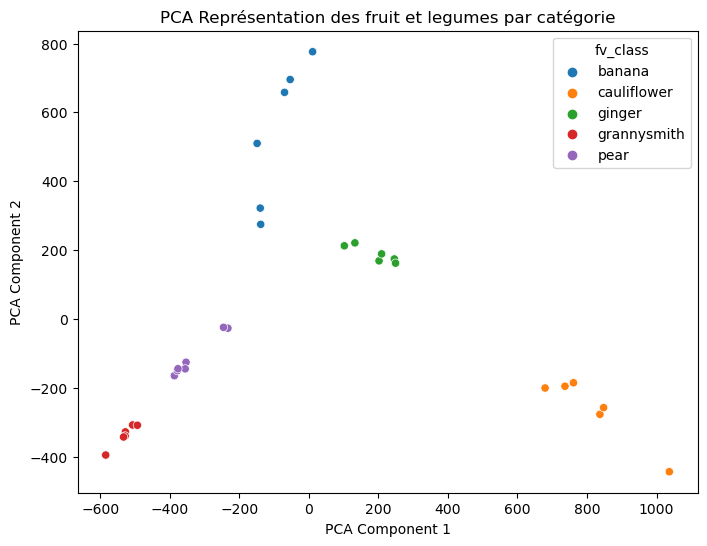

In [11]:
# scatter with seaborn

# start plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=df_pca, x=0, y=1, hue='fv_class')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Représentation des fruit et legumes par catégorie')
plt.show()